Step 0: Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Step 1: Data Collection

In [17]:
import pandas as pd
d1 = pd.read_csv('gdrive/My Drive/bank_reviews3.csv')
d2 = pd.read_csv('gdrive/My Drive/bank_reviews_na.csv', encoding='latin-1')

Step 2: Data Preprocessing

In [3]:
import nltk # natural language toolkit
import re # regular expression
from nltk.corpus import stopwords # general words like "the", "and", etc
from nltk.stem import WordNetLemmatizer

In [4]:
# NLTK resources (run only once)
nltk.download('stopwords') # stopwords
nltk.download('punkt_tab') # latest version of tokenizer
nltk.download('wordnet') #corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
d1_reviews = d1[['review']].copy() # dataset of only reviews (copy of the reviews column)
d2_reviews = d2[['Reviews']].copy()
lemmatizer = WordNetLemmatizer() # Initialize Lemmatizer: reduces inflected/prefixed/suffixed words into their normal form
stop_words = set(stopwords.words('english')) # list of stop words

In [6]:
def preprocess_text(text): # text preprocessing function
    if pd.isnull(text): # for null reviews
        return ''

    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text) # remove special characters and numbers

    tokens = nltk.word_tokenize(text) # tokenize the text

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # lemmatization and removal of stop words

    return ' '.join(tokens) # re-join tokens into a string

In [19]:
# processed reviews
d1_reviews['cleaned_review'] = d1_reviews['review'].apply(preprocess_text)
d2_reviews['cleaned_review'] = d2_reviews['Reviews'].apply(preprocess_text)

Step 3: Sentiment Analysis

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (run only once)
nltk.download('vader_lexicon') # VADER is a scoring system optimized for social media and review text
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [9]:
def get_sentiment(text): # sentiment analysis COMPOUND scoring function
    if pd.isnull(text) or text.strip() == '':
        return 'Neutral'
    scores = sia.polarity_scores(text)
    compound = scores['compound'] # categorization values added as a column to scores array
    if compound > 0.05:
        return 'Positive'
    elif compound < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [20]:
# apply sentiment analysis function to cleaned reviews and add result sentiment as column
d1_reviews['sentiment'] = d1_reviews['cleaned_review'].apply(get_sentiment)
d2_reviews['sentiment'] = d2_reviews['cleaned_review'].apply(get_sentiment)

Step 4. Topic Modeling
- Text Vectorization: Convert text into a format usable by LDA (Bag-of-Words using CountVectorizer).
- LDA Topic Modeling: Identify key topics in each sentiment category.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [21]:
d1_positive_reviews = d1_reviews[d1_reviews['sentiment'] == 'Positive']['cleaned_review']
d1_neutral_reviews = d1_reviews[d1_reviews['sentiment'] == 'Neutral']['cleaned_review']
d1_negative_reviews = d1_reviews[d1_reviews['sentiment'] == 'Negative']['cleaned_review']

d2_positive_reviews = d2_reviews[d2_reviews['sentiment'] == 'Positive']['cleaned_review']
d2_neutral_reviews = d2_reviews[d2_reviews['sentiment'] == 'Neutral']['cleaned_review']
d2_negative_reviews = d2_reviews[d2_reviews['sentiment'] == 'Negative']['cleaned_review']

In [31]:
# Enhanced Function for Topic Modeling with Prettier Graphs
color_mapping = {'Positive': 'blue', 'Neutral': 'orange', 'Negative': 'red'}

def perform_lda(reviews, sentiment, num_topics=1, num_words=10):
    """
    Perform LDA topic modeling and visualize results with sentiment-specific bar colors.

    Parameters:
    - reviews: pd.Series or list of reviews (text data).
    - sentiment: str, sentiment type ('Positive', 'Neutral', or 'Negative').
    - num_topics: int, number of topics for LDA (default=1).
    - num_words: int, number of top words to display per topic (default=10).
    """
    if reviews.empty:
        print(f"No reviews available for {sentiment} sentiment.")
        return

    # Vectorize Text Data
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(reviews)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(doc_term_matrix)

    # Display Topics
    vocab = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda.components_):
        print(f"\nTopic {idx+1} ({sentiment} Sentiment):")
        print([vocab[i] for i in topic.argsort()[-num_words:]])

    # Improved Visualization
    fig, axs = plt.subplots(num_topics, 1, figsize=(10, 6 * num_topics), dpi=100)
    if num_topics == 1:
        axs = [axs]  # Ensure axs is iterable for one topic

    bar_color = color_mapping.get(sentiment, 'skyblue')  # Default to 'skyblue' if sentiment not in mapping

    for topic_idx, topic in enumerate(lda.components_):
        top_features = [vocab[i] for i in topic.argsort()[-num_words:]]
        weights = [topic[i] for i in topic.argsort()[-num_words:]]

        # Plot bar chart for each topic
        axs[topic_idx].barh(top_features, weights, color=bar_color, edgecolor='black')
        axs[topic_idx].set_title(f"Top {num_words} Words ({sentiment} Sentiment)", fontsize=14)
        axs[topic_idx].set_xlabel("Word Importance (LDA Weight)", fontsize=12)
        axs[topic_idx].set_ylabel("Words", fontsize=12)
        axs[topic_idx].invert_yaxis()  # Place the most significant word at the top
        axs[topic_idx].grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()


🔹 Positive Reviews Topics:

Topic 1 (Positive Sentiment):
['charge', 'salary', 'saving', 'using', 'good', 'balance', 'banking', 'year', 'service', 'bank']


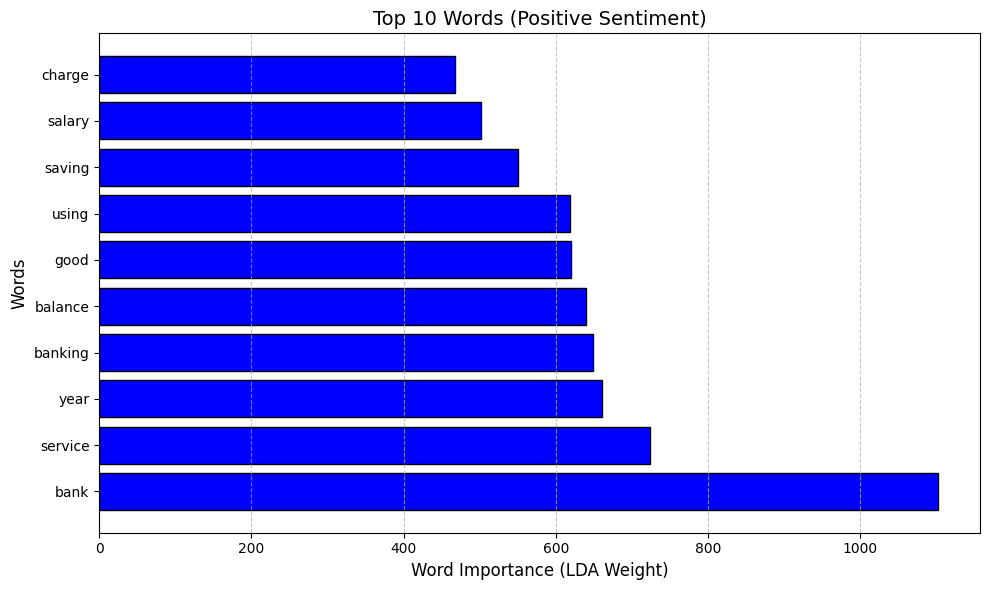


🔸 Neutral Reviews Topics:

Topic 1 (Neutral Sentiment):
['need', 'salary', 'atm', 'maintain', 'minimum', 'saving', 'year', 'charge', 'balance', 'bank']


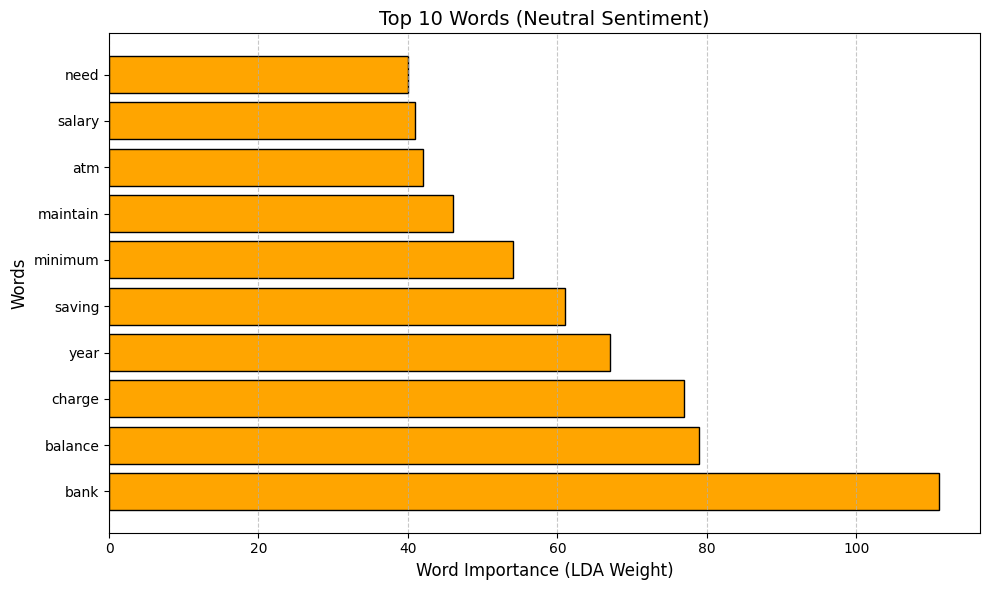


🔻 Negative Reviews Topics:

Topic 1 (Negative Sentiment):
['time', 'need', 'transaction', 'branch', 'charge', 'saving', 'year', 'balance', 'bank', 'account']


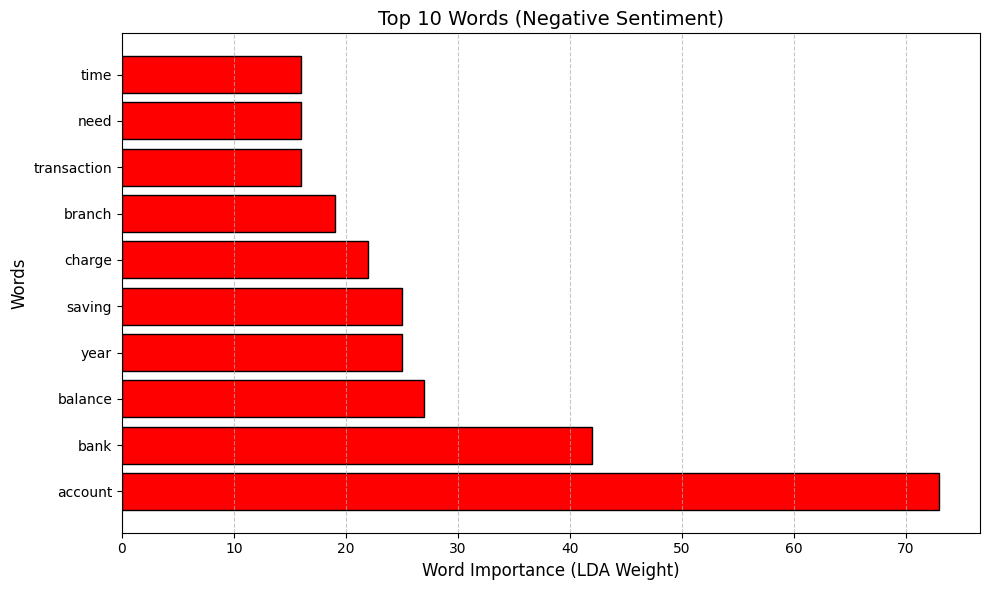

In [32]:
# Perform LDA on Positive, Neutral, and Negative Reviews (d1)
print("🔹 Positive Reviews Topics:")
perform_lda(d1_positive_reviews, sentiment="Positive")

print("\n🔸 Neutral Reviews Topics:")
perform_lda(d1_neutral_reviews, sentiment="Neutral")

print("\n🔻 Negative Reviews Topics:")
perform_lda(d1_negative_reviews, sentiment="Negative")

🔹 Positive Reviews Topics:

Topic 1 (Positive Sentiment):
['great', 'rate', 'work', 'recommend', 'mortgage', 'read', 'home', 'time', 'process', 'loan']


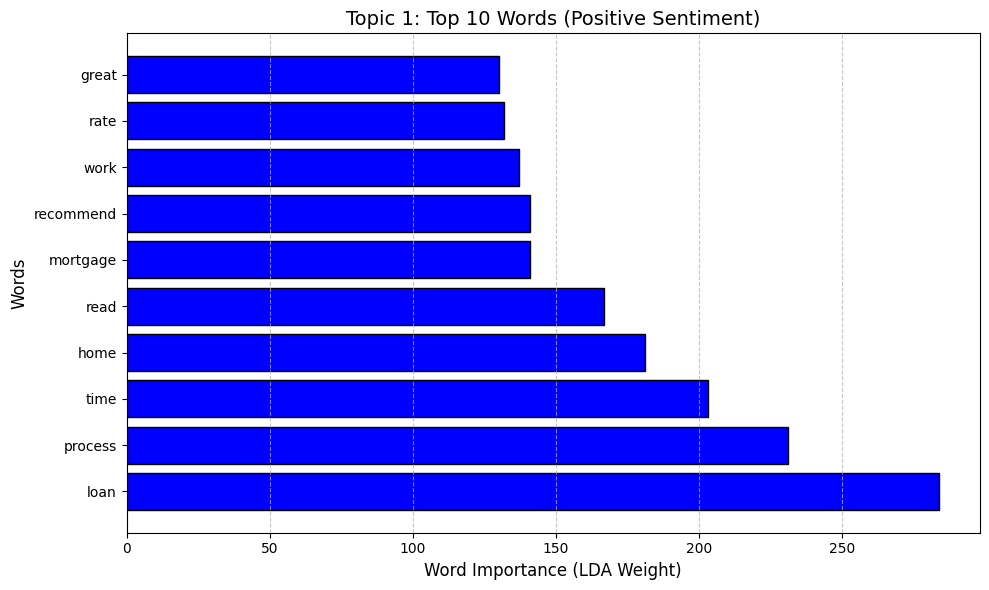


🔸 Neutral Reviews Topics:

Topic 1 (Neutral Sentiment):
['time', 'expired', 'contacted', 'committed', 'house', 'questioned', 'loan', 'communication', 'process', 'poor']


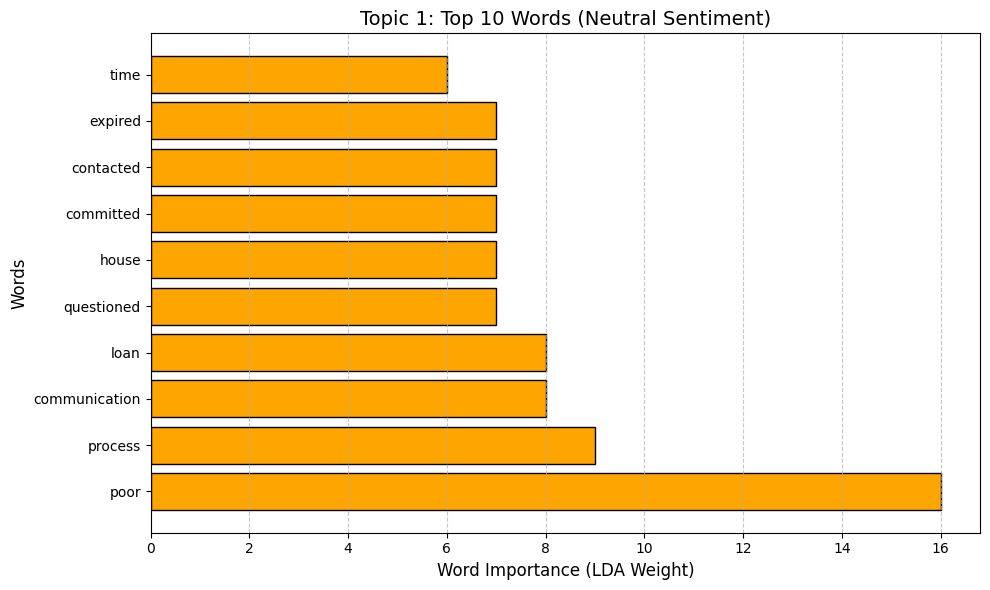


🔻 Negative Reviews Topics:

Topic 1 (Negative Sentiment):
['credit', 'home', 'bank', 'nasb', 'process', 'sent', 'payment', 'read', 'closing', 'loan']


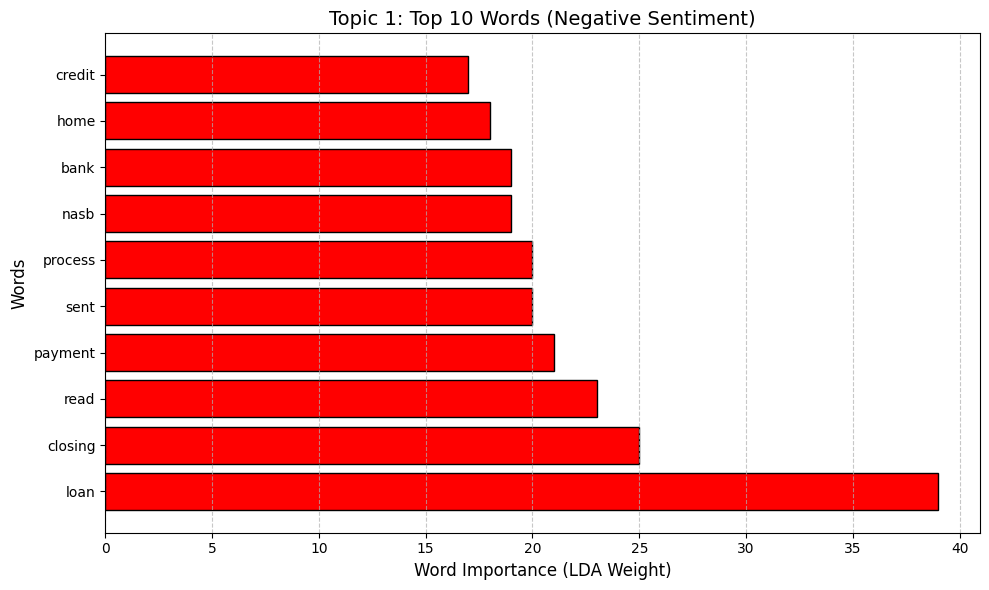

In [24]:
# Perform LDA on Positive, Neutral, and Negative Reviews (d2)
print("🔹 Positive Reviews Topics:")
perform_lda(d2_positive_reviews, sentiment="Positive")

print("\n🔸 Neutral Reviews Topics:")
perform_lda(d2_neutral_reviews, sentiment="Neutral")

print("\n🔻 Negative Reviews Topics:")
perform_lda(d2_negative_reviews, sentiment="Negative")

Highest ranked words (after reducing num_topics to 1):
- Positive: "service" is most prevalent ("bank" is 1st but questionable)
- Neutral: "balance", "charge", "saving"
- Negative: "account"


IMPORTANT: These insights can guide further investigation into specific service areas and help prioritize improvements based on customer sentiment.

Step 5. Preparing confusion matrices to measure classifier accuracy

In [25]:
# Add 'rating' column from df to df_reviews based on the index
d1_reviews['rating'] = d1['rating']
d2_reviews['rating'] = d2['Stars']
# print(df_reviews.head())

In [26]:
import numpy as np

d1_confusion_matrix = np.zeros((3, 3), dtype=int) # Initialize confusion matrix
d2_confusion_matrix = np.zeros((3, 3), dtype=int) # Initialize confusion matrix

# Define sentiment and rating mappings
sentiment_mapping = {'Positive': 0, 'Neutral': 1, 'Negative': 2}

# Update Confusion Matrix
def update_confusion_matrix(confusion_matrix, d_reviews):
    for sentiment, s_index in sentiment_mapping.items():
        confusion_matrix[0][s_index] = len(d_reviews[(d_reviews['rating'] > 3) & (d_reviews['sentiment'] == sentiment)])
        confusion_matrix[1][s_index] = len(d_reviews[(d_reviews['rating'] == 3) & (d_reviews['sentiment'] == sentiment)])
        confusion_matrix[2][s_index] = len(d_reviews[(d_reviews['rating'] < 3) & (d_reviews['sentiment'] == sentiment)])

# Call the function
update_confusion_matrix(d1_confusion_matrix, d1_reviews)
update_confusion_matrix(d2_confusion_matrix, d2_reviews)

# Print the confusion matrices
print(d1_confusion_matrix)
print(d2_confusion_matrix)
# print(confusion_matrix.sum())
print((d1_confusion_matrix.diagonal().sum())/len(d1_reviews))
print((d2_confusion_matrix.diagonal().sum())/len(d2_reviews))

[[777  73  23]
 [ 64   5   2]
 [ 42   3  11]]
[[392   6  12]
 [  0   0   0]
 [ 51   9  35]]
0.793
0.8455445544554455


Step 6. Hypotheses to check for differences in average sentiment analysis performance and sentiment structures.

In [27]:
import math

# Input data number of instances
n1 = len(d1_reviews)
n2 = len(d2_reviews)

# number of correctly classified instances
d1_correct = d1_confusion_matrix.diagonal().sum()
d2_correct = d2_confusion_matrix.diagonal().sum()

# Calculate means
mean_d1 = d1_correct / n1
mean_d2 = d2_correct / n2

# Calculate standard deviations using means as success rates (assuming correct = 1 and wrong = 0)
stddev_d1 = math.sqrt((mean_d1 * (1 - mean_d1)) / n1)
stddev_d2 = math.sqrt((mean_d2 * (1 - mean_d2)) / n2)

# Print results
print(f"Mean (first dataset): {mean_d1:.4f}")
print(f"Standard Deviation (first dataset): {stddev_d1:.4f}")
print(f"Mean (second dataset): {mean_d2:.4f}")
print(f"Standard Deviation (second dataset): {stddev_d2:.4f}")

Mean (first dataset): 0.7930
Standard Deviation (first dataset): 0.0128
Mean (second dataset): 0.8455
Standard Deviation (second dataset): 0.0161


In [28]:
# Calculate variances
variance_d1 = stddev_d1 ** 2
variance_d2 = stddev_d2 ** 2

# Calculate F-statistic
F_statistic = max(variance_d1, variance_d2) / min(variance_d1, variance_d2)

print(f"Variance (first dataset): {variance_d1:.4f}")
print(f"Variance (second dataset): {variance_d2:.4f}")
print(f"F-Statistic: {F_statistic:.4f}")

Variance (first dataset): 0.0002
Variance (second dataset): 0.0003
F-Statistic: 1.5755


In [30]:
from scipy.stats import f

# Degrees of freedom
df1 = len(d1_reviews) - 1
df2 = len(d2_reviews) - 1

# Calculate p-value
p_value = f.sf(F_statistic, df1, df2)

# Critical value for 95% confidence level (alpha = 0.05)
critical_value_95 = f.ppf(0.95, df1, df2)
critical_value_90 = f.ppf(0.90, df1, df2)

print(f"F-Statistic calculated: {F_statistic:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Critical Value (95% confidence): {critical_value_95:.4f}")
print(f"Critical Value (90% confidence): {critical_value_90:.4f}")

F-Statistic calculated: 1.5755
p-value: 5.6918e-09
Critical Value (95% confidence): 1.1374
Critical Value (90% confidence): 1.1055


In [34]:
from scipy.stats import t

# Welch's t-test formula
t_statistic = (mean_d1 - mean_d2) / math.sqrt((variance_d1 / n1) + (variance_d2 / n2))

# Degrees of freedom for Welch's t-test
df = ((variance_d1 / n1) + (variance_d2 / n2))**2 / (
    ((variance_d1 / n1)**2 / (n1 - 1)) + ((variance_d2 / n2)**2 / (n2 - 1))
)

# Calculate p-value for two-tailed test
p_value = 2 * t.sf(abs(t_statistic), df)

# Print results
print(f"T-Statistic: {t_statistic:.4f}")
print(f"Degrees of Freedom: {df:.4f}")
print(f"P-Value: {p_value:.4e}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: The means are significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in the means.")

T-Statistic: -63.8959
Degrees of Freedom: 835.5788
P-Value: 0.0000e+00
Reject the null hypothesis: The means are significantly different.
